<a href="https://colab.research.google.com/github/jusscarrascosa/ImageProcessing-and-Clustering-Projects/blob/main/Image_Clustering_and_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Image Clustering and Feature Extraction**

This notebook continues the image segmentation work by extracting descriptive features and applying unsupervised clustering to group similar regions (flowers, leaves, background). The workflow includes image loading, grayscale conversion and histogram analysis, global and adaptive thresholding for segmentation, feature extraction (color / intensity / texture), dimensionality reduction when needed, clustering (e.g., K-Means), and visualization of the cluster maps and comparison with the thresholded results. The goal is to evaluate how simple thresholding and unsupervised grouping complement each other for object separation in natural images.


---


*Esta notebook continúa el trabajo de segmentación mediante la extracción de características descriptivas y la aplicación de clustering no supervisado para agrupar regiones similares (flores, hojas, fondo). El flujo de trabajo incluye carga de imagen, conversión a monocromo y análisis de histograma, umbralización global y adaptativa para segmentar, extracción de características (color / intensidad / textura), reducción de dimensionalidad cuando corresponda, clustering (por ejemplo K-Means) y visualización de los mapas de cluster comparados con los resultados por umbralización. El objetivo es evaluar cómo la umbralización simple y el agrupamiento no supervisado se complementan para separar objetos en imágenes naturales.*

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from collections import Counter

1. Load image & inspect
*   Read the RGB image (flores.png) with OpenCV and print its dimensions and dtype to confirm shape and format.
2. Grayscale conversion & histogram analysis
*   Convert to grayscale and compute the histogram.
*   Interpret histogram peaks to locate background (low intensities), foliage (mid intensities) and flowers (high intensities). Use the histogram to guide manual threshold selection.
3. Segmentation: global vs. adaptive
*   Apply global thresholding with a manual threshold = 175 and with Otsu’s method (automatic ≈129).
*   Apply adaptive (local) thresholding (ADAPTIVE_THRESH_GAUSSIAN_C, blockSize=51, C=5).
*   Visualize original, manual binary, Otsu binary, and adaptive binary side by side for direct comparison.
*   Justify the manual threshold by linking it to histogram regions (flowers ~250, background 0–150 → manual threshold chosen in the 150–200 window).
4. Feature extraction for clustering
*   Build feature vectors per pixel (or per small patch): color channels (RGB or Lab), grayscale intensity, and simple texture descriptors (patch mean/std, or LBP) and gradient magnitude (Sobel).
*   Stack features into an N x D array (N = pixels or patches).
5. Optional dimensionality reduction
*   If D is large, apply PCA to reduce dimensionality (e.g., to 10 components) for faster clustering and easier visualization.
6. Clustering (K-Means baseline)
*   Run K-Means (choose k by visual inspection, elbow method, or silhouette) and assign cluster labels to pixels/patches.
*   Map cluster labels to a color map and generate a cluster overlay on the original image.
7. Postprocessing & comparison
*   Optionally apply morphological operations (opening/closing) to remove small noisy regions.
*   Compare cluster regions with binary masks (manual / Otsu / adaptive) to see correspondences (flowers vs leaves vs background). Compute simple stats per cluster (area, mean intensity).

















1. Carga de la imagen y verificación
* Leer la imagen RGB (flores.png) con OpenCV y mostrar dimensiones y tipo de dato para confirmar forma y formato.
2. Conversión a monocromo y análisis de histograma
* Convertir a escala de grises y calcular el histograma.
* Interpretar los picos para localizar fondo (intensidades bajas), follaje (intensidades medias) y flores (intensidades altas). Usar el histograma para guiar la selección manual del umbral.
3. Segmentación: global vs. adaptativa
* Aplicar umbral global con umbral manual = 175 y con Otsu (automático ≈129).
* Aplicar umbral adaptativo (ADAPTIVE_THRESH_GAUSSIAN_C, blockSize=51, C=5).
* Visualizar original, binaria manual, binaria Otsu y binaria adaptativa en subplots para comparar.
* Justificar el umbral manual mediante la relación con el histograma (flores ~250, fondo 0–150 → umbral manual elegido en la ventana 150–200).
4. Extracción de características para clustering
* Construir vectores de características por píxel (o por parche): canales de color (RGB o Lab), intensidad en escala de grises, descriptores de textura simples (media/desv. sobre parche, o LBP) y magnitud de gradiente (Sobel).
* Apilar las características en una matriz N x D (N = píxeles o parches).
5. Reducción de dimensionalidad (opcional)
* Si D es grande, aplicar PCA para reducir dimensiones (ej. a 10 componentes), acelerar el clustering y facilitar la visualización.
6. Clustering (K-Means como baseline)
* Ejecutar K-Means (elegir k por inspección visual, método elbow o silhouette) y asignar etiquetas de cluster a píxeles/parches.
* Mapear etiquetas a colores y generar una superposición del mapa de clusters sobre la imagen original.
7. Postprocesado y comparación
* Aplicar operaciones morfológicas (opening/closing) para eliminar pequeñas regiones ruidosas.
* Comparar regiones de clusters con las máscaras binarias (manual / Otsu / adaptativa) para evaluar correspondencias (flores/hojas/fondo). Calcular estadísticas por cluster (área, intensidad media).

(240, 200, 3)


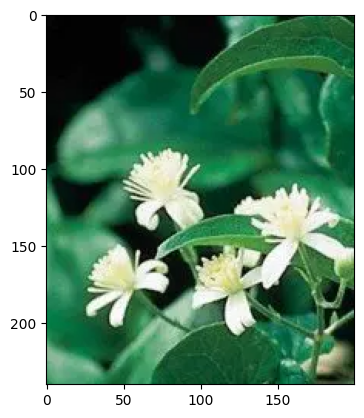

In [ ]:
flor_cv=cv2.imread('/content/flores (1).png')
print(flor_cv.shape)
imagen_rgb = cv2.cvtColor(flor_cv, cv2.COLOR_BGR2RGB)
plt.imshow(imagen_rgb)
plt.show()

In [ ]:
dims=imagen_rgb.shape
cant_filas=dims[0]
cant_columnas=dims[1]
ind=np.indices((cant_filas,cant_columnas))
cant_pixeles=cant_filas*cant_columnas
datos=np.zeros([cant_pixeles,5],dtype='int')

datos[:,0]=ind[0].flatten() #filas
datos[:,1]=ind[1].flatten() #columnas
datos[:,2]=imagen_rgb[:,:,0].flatten() #rojo
datos[:,3]=imagen_rgb[:,:,1].flatten() # verde
datos[:,4]=imagen_rgb[:,:,2].flatten() # azul

df = pd.DataFrame(datos, columns=["fila", "columna","rojo","verde","azul"])

print(df.shape)
print('Base de pixeles:')
df.head()

(48000, 5)
Base de pixeles:


,fila,columna,rojo,verde,azul
0,0,0,7,7,7
1,0,1,7,7,7
2,0,2,7,7,7
3,0,3,7,7,7
4,0,4,8,8,8


In [ ]:
X=datos[:,2:5]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)

In [ ]:
print(kmeans.labels_)
print(kmeans.labels_.shape)

[2 2 2 ... 0 0 0]
(48000,)


In [ ]:
df_clusters=df.copy() #nuevo Data Frame
df_clusters['kmedias_3']=kmeans.labels_
df_clusters.head()

,fila,columna,rojo,verde,azul,kmedias_3
0,0,0,7,7,7,2
1,0,1,7,7,7,2
2,0,2,7,7,7,2
3,0,3,7,7,7,2
4,0,4,8,8,8,2


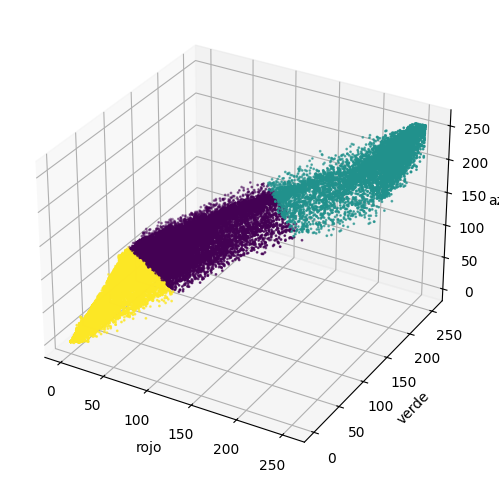

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
variables=["rojo","verde","azul"]
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df[variables[0]].values, df[variables[1]].values, df[variables[2]].values,c=kmeans.labels_, s=1)
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])
plt.show()

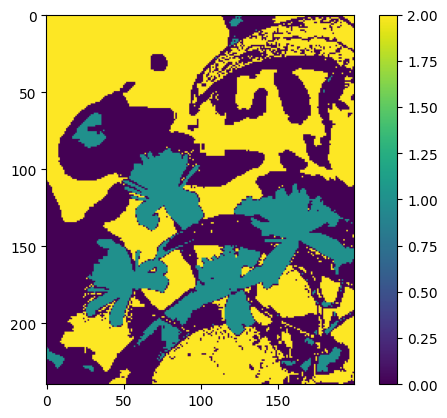

In [ ]:
imagen_kmedias=np.reshape(kmeans.labels_, (cant_filas,cant_columnas))
plt.imshow(imagen_kmedias)
plt.colorbar()
plt.show()

Results / Resultados

Histogram & thresholding: The histogram shows a dominant dark background peak, a broad mid-intensity band corresponding to leaves, and a high-intensity region where flowers concentrate. Manual thresholding at 175 isolates flowers more reliably than Otsu’s automatic threshold (~129), which tends to include some leaf regions as foreground.

Adaptive thresholding: The adaptive method successfully handles local illumination variations and recovers flower regions where global Otsu fails, but may introduce small fragmented areas that require morphological cleaning.

Clustering outcome (qualitative): Clustering based on combined color and texture features groups pixels into coherent regions approximating flowers, leaves, and background. Clusters corresponding to flowers show higher mean intensity and smaller, more localized regions; leaf clusters occupy larger contiguous areas. Some cluster overlap with threshold-based masks is observed — clustering complements thresholding by capturing texture/color cues that a single grayscale threshold cannot.

Practical notes: Postprocessing (morphology) improves both binary masks and cluster maps, reducing salt-and-pepper and small isolated components.



---

*Histograma y umbralización: El histograma muestra un pico dominante de fondo oscuro, una banda amplia de intensidad media correspondiente a las hojas y una región de alta intensidad donde se concentran las flores. La umbralización manual en 175 aísla mejor las flores que el umbral automático de Otsu (~129), que tiende a incluir partes de las hojas como primer plano.*

*Umbralización adaptativa: El método adaptativo maneja bien variaciones locales de iluminación y recupera regiones florales donde Otsu falla, aunque puede generar áreas fragmentadas que requieren limpieza morfológica.*

*Resultado del clustering (cualitativo): El clustering basado en características combinadas de color y textura agrupa píxeles en regiones coherentes que aproximan flores, hojas y fondo. Los clusters asociados a flores presentan mayor intensidad media y suelen ser regiones más pequeñas y localizadas; los clusters de hojas ocupan áreas más extensas. Existe cierta sobreposición entre clusters y máscaras por umbral — el clustering complementa la umbralización al capturar información de textura/color que un umbral en escala de grises no detecta.*

*Notas prácticas: El postprocesado morfológico mejora tanto las máscaras binarias como los mapas de cluster, reduciendo el ruido tipo sal y pimienta y componentes aislados.*
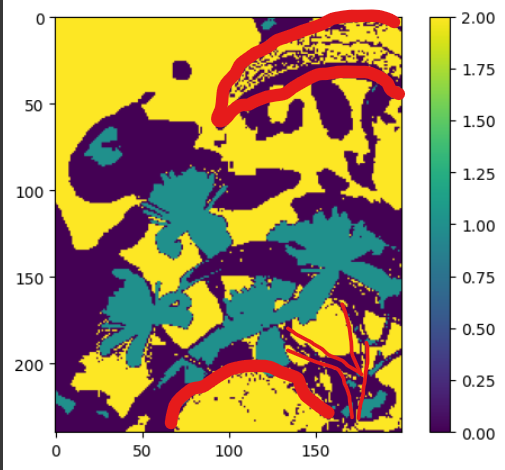 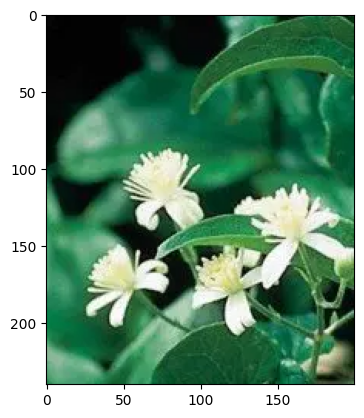

In [ ]:
img= cv2.imread('/content/flores (1).png',0)
umbral_manual = 175
ret, binaria= cv2.threshold(img, umbral_manual, 255, cv2.THRESH_BINARY)
ret1, binaria1 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

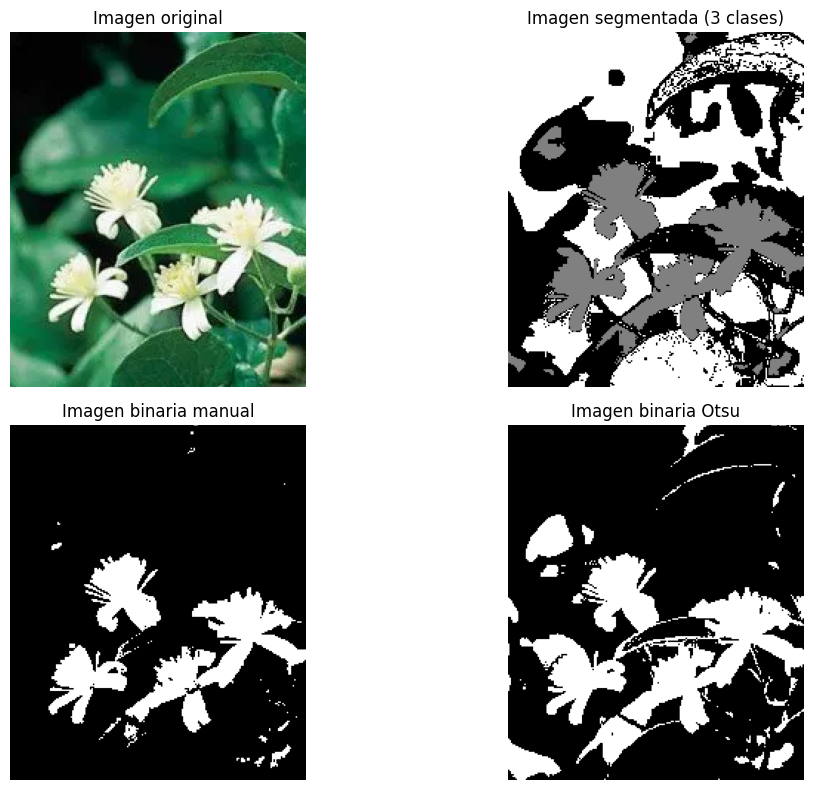

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].imshow(imagen_rgb)
axs[0, 0].set_title("Imagen original")
axs[0, 0].axis("off")
axs[0, 1].imshow(imagen_kmedias, cmap='gray')
axs[0, 1].set_title("Imagen segmentada (3 clases)")
axs[0, 1].axis("off")
axs[1, 0].imshow(binaria, cmap='gray')
axs[1, 0].set_title("Imagen binaria manual")
axs[1, 0].axis("off")
axs[1, 1].imshow(binaria1, cmap='gray')
axs[1, 1].set_title("Imagen binaria Otsu")
axs[1, 1].axis("off")

plt.tight_layout()
plt.show()

#**Conclusions / Conclusiones**
Histogram-driven decisions are essential: analyzing intensity distribution allowed a targeted manual threshold (175) that outperformed Otsu in this scene.

Adaptive thresholding is valuable for non-uniform illumination, but usually requires morphological cleanup.

Clustering on combined feature sets (color + texture + gradient) provides richer separation than grayscale thresholding alone and helps disambiguate leaf/flower regions that overlap in intensity.

Recommended next steps: compute features on superpixels (SLIC) to reduce noise and complexity, experiment with CNN embeddings (pretrained networks) for more discriminative features, and include a small annotated set to validate clusters quantitatively (silhouette, pixel-wise IoU). These improvements will increase robustness and prepare the pipeline for more advanced tasks (e.g., supervised segmentation or object detection).



---


*Las decisiones guiadas por el histograma son claves: el análisis de la distribución de intensidades permitió elegir un umbral manual (175) que superó a Otsu en esta escena.*

*La umbralización adaptativa es útil ante iluminación no uniforme, aunque habitualmente exige limpieza morfológica.*

*El clustering sobre conjuntos de características combinadas (color + textura + gradiente) ofrece una separación más rica que la umbralización en escala de grises y ayuda a diferenciar regiones de hojas/ flores con solapamiento en intensidad.*

*Pasos recomendados: extraer características sobre superpíxeles (SLIC) para reducir ruido y complejidad, probar embeddings de CNN preentrenados para features más discriminativos, e incorporar un conjunto anotado pequeño para validar clusters de forma cuantitativa (silhouette, IoU por píxel). Estas mejoras aumentarán la robustez y prepararán la tubería para tareas avanzadas (segmentación supervisada o detección de objetos).*
